In [1]:
import sys
sys.path.append("..")

# basics
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
import copy
import qutip.floquet as floq
import qutip

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import pulse.tukey as tukey
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver
from tqdm import tqdm as tqdm

# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor

pass

# Critical Power Exploration
There seems to be a amplitude at which the system transitions into a floquet system, below that amp nothing really happens?

In [2]:
import dill
def load_via_dill(name):
    name = "../save_data/" + name + ".dill"
    with open(name, "rb") as f:
        return dill.load(f)

results = load_via_dill("params_as_function_of_amplitude_Nov18_combined_results")
results[0]

{'amplitude': 4.799655442984406,
 'offset': 0.04697417721616526,
 'duration': 501.92632487823903,
 'fidelity': 0.9990204782209428,
 'end_early': True}

In [100]:
amplitude = results[0]['amplitude']
ramp_slope = 0.5
cut_factor = 3

guess_offset = results[0]['offset']
guess_duration = results[0]['duration']

In [101]:
# # Find a good pulse to start with
# offset_range_width = 1
# tlist = np.linspace(0, guess_duration, int(guess_duration*5))
# guess_fids = []
# guess_offset_range = np.linspace(guess_offset-offset_range_width, guess_offset+offset_range_width)
# for offset in tqdm(guess_offset_range):
#     tukey.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=ramp_slope, tlist=tlist)
#     solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
#     expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
#     fidelity = expectation_values[1][-1]
#     guess_fids.append(fidelity)

In [102]:
# plt.plot(guess_offset_range, guess_fids)
# plt.xlabel("frequency offset from initial guess")
# plt.ylabel("fidelity")
# plt.show()
# guess_offset = guess_offset_range[np.argmax(guess_fids)]

In [103]:
# # Find a good pulse to start with
# def cost(parameters, constants):
#     # parameters = [offset, duration]
#     offset = parameters[0]
#     duration = parameters[1]
#     # constants = [amplitude, ramp_coeff]
#     amplitude = constants[0]
#     ramp_slope = constants[1]
#     cut_factor = constants[2]
#     tlist = np.linspace(0, duration, int(duration*5))
#     tanh.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
#     solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tanh.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
#     expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
#     fidelity = expectation_values[1][-1]
#     # print(fidelity, offset, duration)
#     return (1-fidelity)

# result1 = sp.optimize.minimize(cost, [guess_offset, guess_duration], [amplitude, ramp_slope, cut_factor], method="Nelder-Mead", options={"disp":True})

In [104]:
# t_max = result1.x[1]
# offset = result1.x[0]
# freq = system.first_energy_spacing/3 - offset
# durations = np.arange(0, t_max, (2*np.pi)/(freq*20))

In [107]:
t_max = guess_duration * 3
offset = guess_offset
freq = system.first_energy_spacing/3 - offset
durations = np.arange(0, t_max, (2*np.pi)/(freq*20))

10.0%. Run time:   4.72s. Est. time left: 00:00:00:42
20.0%. Run time:   9.65s. Est. time left: 00:00:00:38
30.0%. Run time:  14.24s. Est. time left: 00:00:00:33
40.0%. Run time:  17.56s. Est. time left: 00:00:00:26
50.0%. Run time:  21.03s. Est. time left: 00:00:00:21
60.0%. Run time:  24.81s. Est. time left: 00:00:00:16
70.0%. Run time:  28.62s. Est. time left: 00:00:00:12
80.0%. Run time:  32.51s. Est. time left: 00:00:00:08
90.0%. Run time:  36.73s. Est. time left: 00:00:00:04
Total run time:  40.95s
fidelity 0.9371282427647417


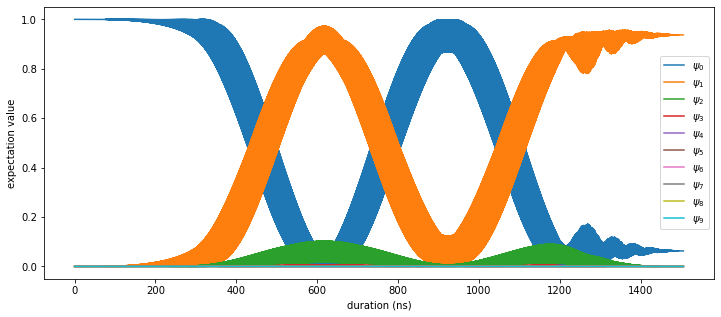

In [108]:
# Graph applied pulse

tanh.setup(amplitude, freq, ramp_slope, durations)
tukey.setup(amplitude, freq, ramp_slope, durations)

s = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, durations, system.starting_state, pbar=True)

graph.graph_solution(s, system)
print("fidelity", expv.expectation_value(s.final_state, system.target_state))

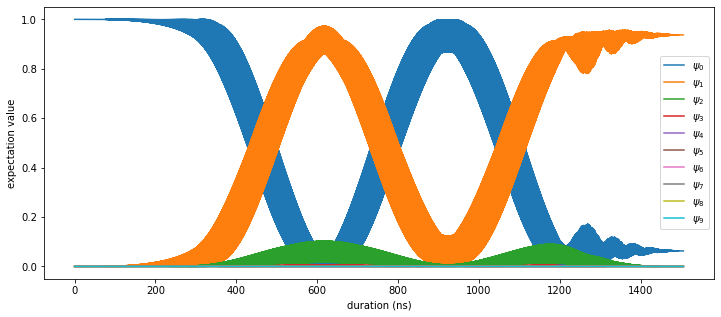

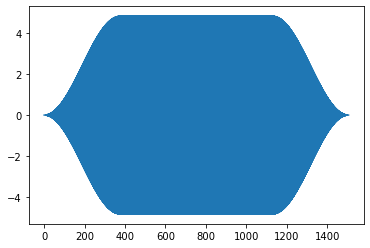

In [109]:
graph.graph_solution(s, system)
plt.show()
plt.plot(durations, tukey.get_pulse(durations))

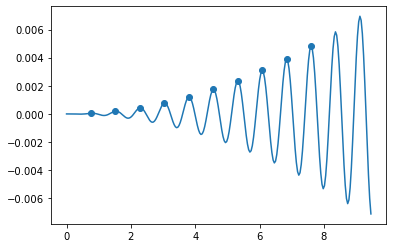

In [110]:
# Create list of points at peaks of pulse

dur_points = np.arange(0, t_max, (2*np.pi)/(freq))[::1]
dur_points = dur_points[1:-1]
pulse = tukey.get_pulse(durations)
num_of_points = 250
num_of_durPoints = 10

plt.plot(durations[:num_of_points], pulse[:num_of_points])
plt.scatter(dur_points[:num_of_durPoints], tukey.get_pulse(dur_points)[:num_of_durPoints])


In [111]:
# utility functions 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if np.amin(np.abs(array - value)) > 1e-12:
        print("error, duration does not exactly exist!", value, array[idx])
    return idx

def overlap(state1, state2):
    return (np.transpose(np.matrix(state1.full())) * np.matrix(state2.full())).item()

# generate floquet kets
kets = []
energies = []
for dur in dur_points:
    dur_amp = tukey.pulse_func(dur)
    def steady(t, args=None):
        return dur_amp * np.cos(freq * t)
    H = [system.H0, [system.H1, steady]]

    floquet_kets, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
    kets.append(floquet_kets)
    energies.append(quasi_energies)

# sort floquet kets
sorted_kets = [np.array(kets[0]).reshape((10,10))]
sorted_energies = [np.array(energies[0])]
for i in range(1, len(dur_points)):
    reshaped_ket = np.array(kets[i]).reshape((10,10))
    m = np.abs(np.dot( (sorted_kets[-1]), np.transpose(reshaped_ket)  ))**2
    row_ind, col_ind = sp.optimize.linear_sum_assignment(1-m)
    # print(col_ind)
    sorted_kets.append( reshaped_ket[col_ind] )
    sorted_energies.append( energies[i][col_ind] )

# correctly order sorted kets
expv_for_sorted_unordered_kets = []
dur = dur_points[0]
index_of_dur = find_nearest(durations, dur)
ordered_energies = copy.deepcopy(sorted_energies)
for k in sorted_kets[0]:
    expv_for_sorted_unordered_kets.append(qutip.expect(qutip.ket2dm(s.states[index_of_dur]), qutip.Qobj(k)))
for t in range(0, len(sorted_kets)):
    temp = []
    temp_energies = []
    for i in list(np.flip(np.argsort(expv_for_sorted_unordered_kets))):
        temp.append(sorted_kets[t][i])
        temp_energies.append(sorted_energies[t][i])
    sorted_kets[t] = temp
    ordered_energies[t] = temp_energies
# sorted_kets = np.array(sorted_kets)[list(np.flip(np.argsort(expv_for_sorted_unordered_kets)))]


# find overlaps of sorted kets
overlaps = []
expectation_values = []
for i in range(len(dur_points)):
    ket = sorted_kets[i]
    dur = dur_points[i]
    index_of_dur = find_nearest(durations, dur)
    overlaps_at_this_dur = []
    expv_at_this_dur = []
    for k in ket:
        expv_at_this_dur.append(qutip.expect(qutip.ket2dm(s.states[index_of_dur]), qutip.Qobj(k)))
        overlaps_at_this_dur.append(overlap(s.states[index_of_dur], qutip.Qobj(k)))
    overlaps.append(np.array(overlaps_at_this_dur))
    expectation_values.append(np.array(expv_at_this_dur))

overlaps = np.transpose(np.array(overlaps))
expectation_values = np.transpose(np.array(expectation_values))

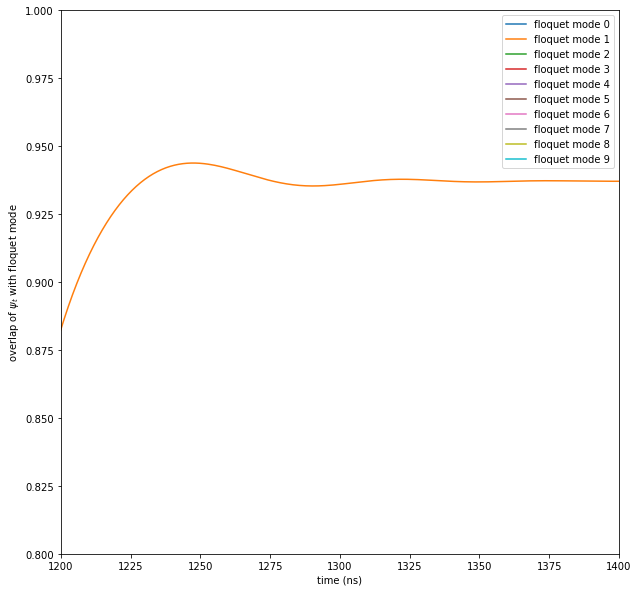

In [125]:
plt.figure(figsize=(10,10))
for i in range(0, len(expectation_values)):
    o = expectation_values[i]
    plt.plot(dur_points, o, label=r'floquet mode %i' % i)
# plt.plot(dur_points, overlaps, label=labeled_overlaps)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'overlap of $\psi_t$ with floquet mode')
plt.ylim((0.8, 1.0))
plt.xlim((1200, 1400))
# plt.axvline(440, c="black")
# plt.axvline(3975, c="black")
# plt.axvline(4050, c="black")
# plt.axvline(4600, c="black")
plt.show()

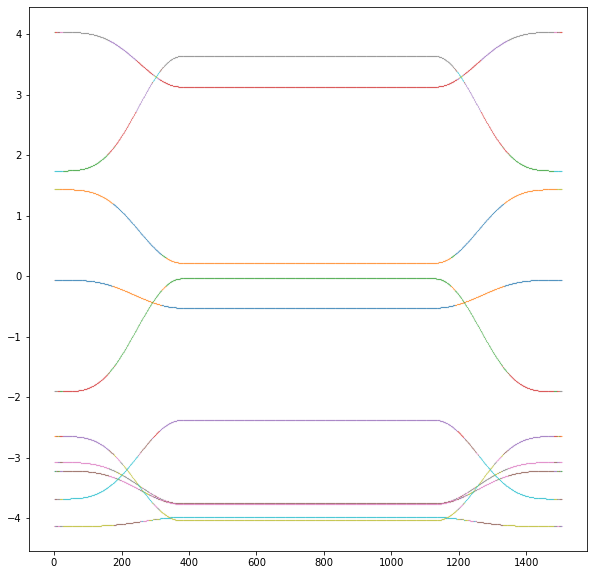

In [113]:
energies = np.array(energies)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(dur_points, energies[:,i], s=0.01)
plt.show()

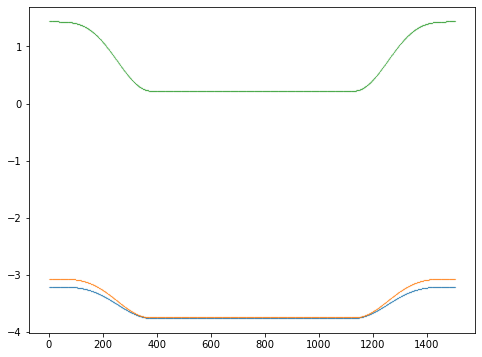

In [114]:
ordered_energies = np.array(ordered_energies)
plt.figure(figsize=(8,6))
for i in range(3):
    plt.scatter(dur_points, ordered_energies[:,i], s=0.01)
plt.show()

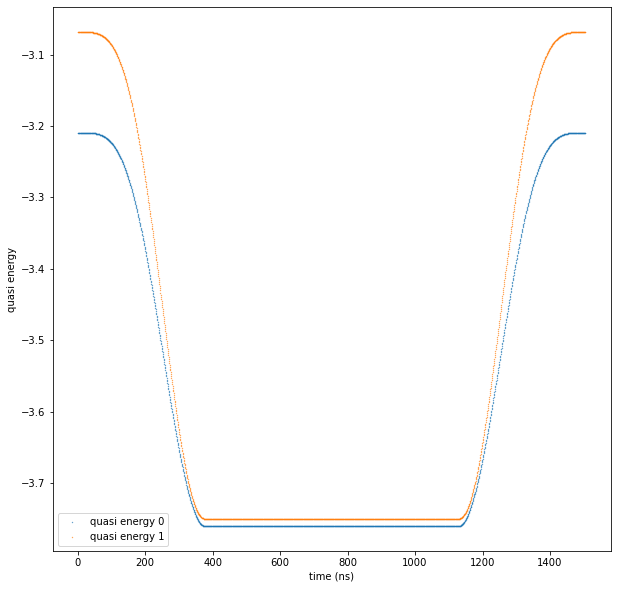

In [121]:
plt.figure(figsize=(10,10))
for i in range(2):
    # plt.plot(dur_points, expectation_values[i], label=r'floquet mode %i' % i)
    plt.scatter(dur_points, ordered_energies[:,i], s=0.1, label=r'quasi energy %i' % i)

# plt.scatter(dur_points, ordered_energies[:,0], s=0.1, label=r'quasi energy %i' % 0)
# plt.scatter(dur_points, ordered_energies[:,9], s=0.1, label=r'quasi energy %i' % 9)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'quasi energy')
# plt.axvline(440, c="black")
# # plt.axvline(3975, c="black")
# # plt.axvline(4050, c="black")
# plt.axvline(4600, c="black")
# plt.ylim((-0.1, 1.1))
plt.show()

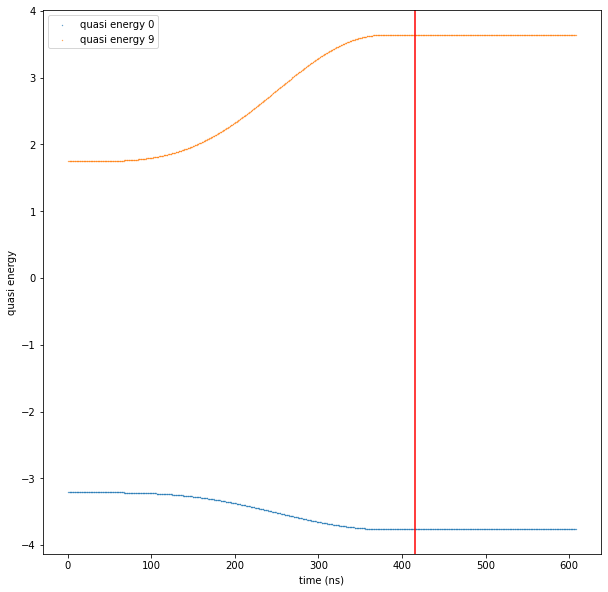

In [116]:
plt.figure(figsize=(10,10))
# for i in range(10):
#     # plt.plot(dur_points, expectation_values[i], label=r'floquet mode %i' % i)
#     plt.scatter(dur_points, ordered_energies[:,i], s=0.1, label=r'quasi energy %i' % i)
i = 800
plt.scatter(dur_points[:i], ordered_energies[:,0][:i], s=0.1, label=r'quasi energy %i' % 0)
plt.scatter(dur_points[:i], ordered_energies[:,9][:i], s=0.1, label=r'quasi energy %i' % 9)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'quasi energy')
plt.axvline(416, c="red")
# # plt.axvline(3975, c="black")
# # plt.axvline(4050, c="black")
# plt.axvline(4600, c="black")
# plt.ylim((-0.1, 1.1))
plt.show()

1150.2364615762083


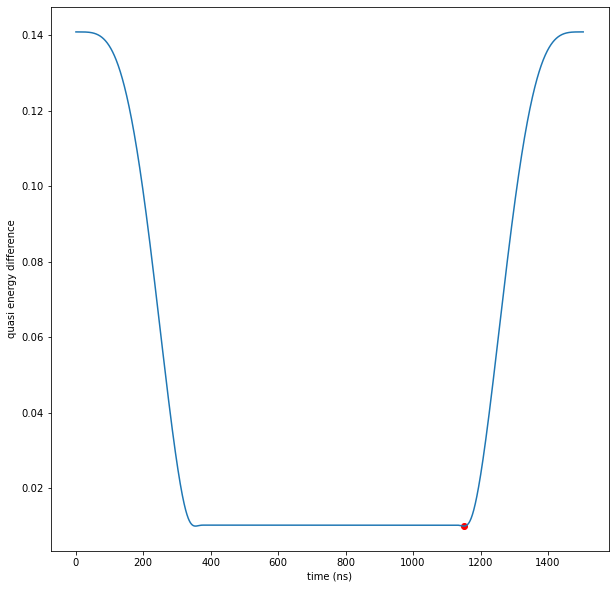

In [123]:
energy_diff = np.abs(np.array(ordered_energies[:,0]) - np.array(ordered_energies[:,1]))
plt.figure(figsize=(10,10))
plt.xlabel("time (ns)")
plt.ylabel("quasi energy difference")
plt.plot(dur_points, energy_diff)
plt.scatter(dur_points[np.argmin(energy_diff)], energy_diff[np.argmin(energy_diff)],  c="red")
print(dur_points[np.argmin(energy_diff)])

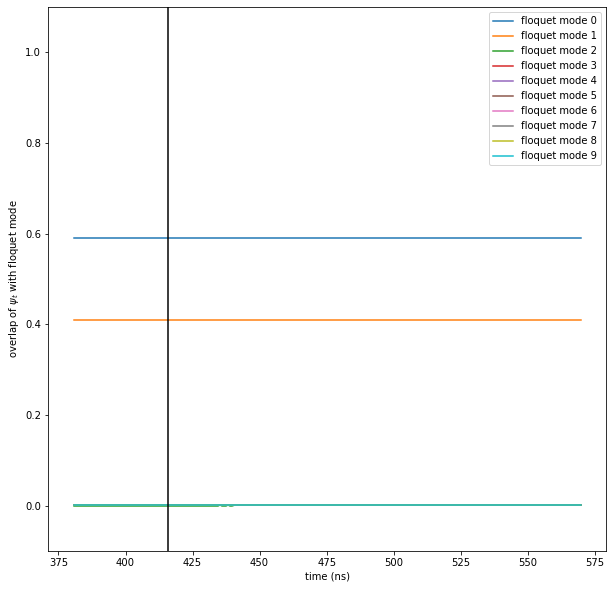

In [118]:
plt.figure(figsize=(10,10))
j = 750
k = 500
for i in range(0, len(expectation_values)):
    plt.plot(dur_points[k:j], expectation_values[i][k:j], label=r'floquet mode %i' % i)
# plt.plot(dur_points, overlaps, label=labeled_overlaps)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'overlap of $\psi_t$ with floquet mode')
plt.ylim((-0.1, 1.1))
plt.axvline(416, c="black")
# plt.axvline(3975, c="black")
# plt.axvline(4050, c="black")
# plt.axvline(4600, c="black")
plt.show()

In [128]:
freq * 2 * np.pi

51.96351032994714

In [ ]:
# Generate Bloch Sphere Rotation

# xs = []
# ys = []
# zs = []
# overlaps = np.transpose(overlaps)
# for i in range(0, len(overlaps)):
#     c0 = overlaps[i,3]
#     c1 = overlaps[i,4]
#     xs.append( np.conjugate(c0) * c1 + c0 * np.conjugate(c1) )
#     ys.append( -1j * np.conjugate(c0) * c1 + 1j * c0 * np.conjugate(c1) )
#     zs.append( np.conjugate(c0) * c0 - c1 * np.conjugate(c1) )

#     # xs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmax()))
#     # ys.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmay()))
#     # zs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmaz()))
#     # vecs.append([xs[-1], ys[-1], zs[-1]])


# from matplotlib import pyplot, animation
# from mpl_toolkits.mplot3d import Axes3D

# fig = pyplot.figure()
# ax = Axes3D(fig, azim=-40, elev=30)
# sphere = qutip.Bloch(axes=ax)

# def animate(i):
#     sphere.clear()
#     sphere.add_points([xs[i:i+1], ys[i:i+1], zs[i:i+1]])
#     sphere.make_sphere()
#     return ax

# def init():
#     sphere.vector_color = ['r']
#     return ax

# ani = animation.FuncAnimation(fig, animate, np.arange(len(xs)),
#                             init_func=init, blit=False, repeat=False)

# ani.save('%s_bloch_sphere.mp4' % "tanh_%f" % amp, fps=20)

In [ ]:
# Look at how much floquet states occupy fock states during flat top driving

def getFockStateOccupancy(ket):
    overlaps = []
    for fock_ket in system.basis_states:
        overlaps.append(expv.expectation_value(qutip.Qobj(ket.reshape(1,10)), fock_ket))
    return overlaps

for floquet_mode_of_interest in range(0, len(sorted_kets)):
    fig=plt.figure()
    n=len(dur_points) #Number of frames
    barcollection = plt.bar(range(len(system.basis_states)),getFockStateOccupancy(sorted_kets[0][floquet_mode_of_interest]))

    def animate(i):
        y=getFockStateOccupancy(sorted_kets[i][floquet_mode_of_interest])
        for i, b in enumerate(barcollection):
            b.set_height(y[i])

    anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=n,
                                interval=100)

    anim.save('floquet_mode_%i_@_amplitude=%f.mp4' % (floquet_mode_of_interest, amplitude),writer=animation.FFMpegWriter(fps=10))

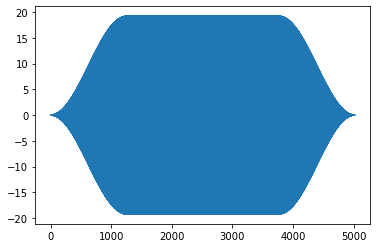

In [30]:
plt.plot(durations, tukey.get_pulse(durations))